<a href="https://colab.research.google.com/github/martaarozarena/KSchool-Master-Final-Project/blob/master/exog_varaibles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [217]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 8)

In [304]:
# We select the sheets to be used in the Oxford Covid Policy tracker and the countries our project will be working on:
sheets = ["c1_schoolclosing","c2_workplaceclosing","c3_cancelpublicevents","c4_restrictionsongatherings", \
          "c5_closepublictransport","c6_stayathomerequirements","c7_domestictravel","c8_internationaltravel", \
          "h1_publicinfocampaign","h2_testingpolicy","h3_contacttracing"]
countries = 'Denmark|Germany|Spain|Finland|Italy|Sweden|France|Norway|United Kingdom' \
            '|United States|Canada|Mexico' \
            '|Australia|Indonesia|Malaysia|Philippines|Thailand|Hong Kong|Vietnam|China|India|Japan|Singapore|Taiwan' \
            '|Saudi Arabia|United Arab Emirates'
initialdate = "01-01-2020"
#enddate="30-06-2020"

# Downloading and preparing the Oxford Covid Policy Tracker data

In [353]:
# Downloading Oxford Covid Policy Tracker
url1 = "https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/timeseries/OxCGRT_timeseries_all.xlsx"
var = pd.read_excel(url1,sheet_name=sheets)

In [354]:
for i in var.keys():
  var[i]=var[i].drop("CountryCode",axis=1)
  var[i].index=var[i].CountryName
  var[i]=var[i].drop("CountryName",axis=1)
  var[i]=var[i][:-3]
  var[i]=var[i].T
  var[i]=var[i].loc[:,var[i].columns.str.contains(countries, regex=True)]
  var[i].index=pd.to_datetime(var[i].index,format="%d%b%Y")
#  var[i]=var[i].truncate(initialdate,enddate)

In [355]:
b=1
for i in sheets:
  if b==1: 
    var[i].columns="{}_".format(i[3:])+var[i].columns
    exogenas=var[i]
  else:
    concat=var[i]
    concat.columns="{}_".format(i[3:])+var[i].columns
    exogenas=pd.concat([exogenas,concat],axis=1)
  b=b+1

In [356]:
exogenas.shape

(231, 286)

# Downloading and preparing the mask wearing data (YouGov)

In [357]:
# We download the mask wearing data
url2 = "https://drive.google.com/file/d/15S6nC4NKDnTj-P6jCcf1LAoH7bgoIzEv/view?usp=sharing"
path2 = 'https://drive.google.com/uc?export=download&id='+url2.split('/')[-2]
var_percent_mask = pd.read_csv(path2, sep=";", parse_dates=['DateTime'], index_col=['DateTime'])

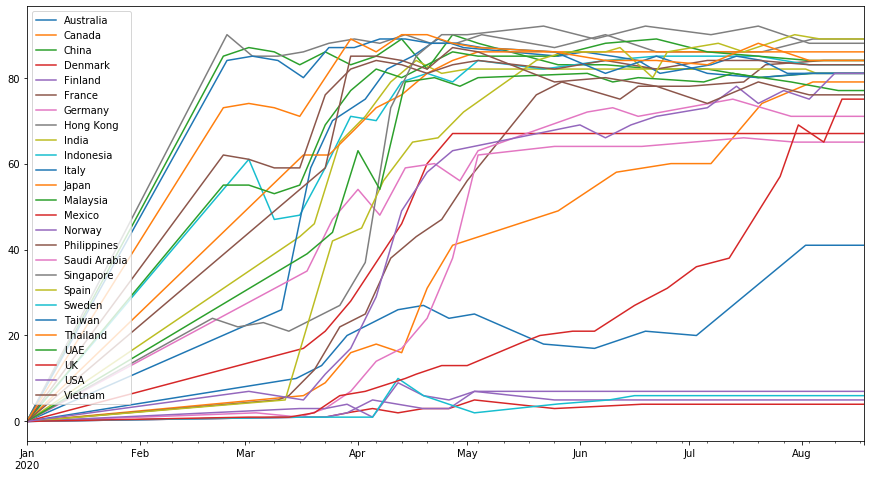

In [358]:
# We extend the dates to match those of the general exogenous dataframe, and we interpolate to fill all the missing values (initializing the series at 0)
var_percent_mask.index = pd.to_datetime(var_percent_mask.index).date
var_percent_mask = var_percent_mask.reindex(exogenas.index)
var_percent_mask.iloc[0] = 0
var_percent_mask = var_percent_mask.interpolate(method='linear')
var_percent_mask.plot()

In [359]:
#rename the variable's columns to be added in the general dataframe
var_percent_mask.columns = "mask_"+var_percent_mask.columns
var_percent_mask.rename(columns={"mask_UAE" : "mask_United Arab Emirates", "mask_UK":"mask_United Kingdom", "mask_USA" : "mask_United States"}, inplace=True)

In [360]:
#add the mask data to the rest of exogenous dataframe
exogenas = pd.concat([exogenas,var_percent_mask],axis=1)

In [361]:
exogenas.shape

(231, 312)

# Downloading and preparing the Flights data (we only have it available for Europe)

In [246]:
#Downloading daily flights from Eurocontrol
#url3 = "https://drive.google.com/file/d/1jLzSGGbQY8OyD1YTNZAJFRmvxy7lA2V_/view?usp=sharing"
#path3 = 'https://drive.google.com/uc?export=download&id='+url3.split('/')[-2]
url3 = 'https://ansperformance.eu/download/xls/Airport_Traffic.xlsx'
flights = pd.read_excel(url3, sheet_name="DATA", date_parser="FLT_DATE", index_col ="FLT_DATE")

In [362]:
# Extractin 
for i in countries.split('|'):
    flights_country = flights[flights["STATE_NAME"]==i]
    flights_country = flights_country.resample("1D").sum()
    flights_country_arr = flights_country['FLT_ARR_1'].truncate(before=initialdate)
    flights_country_arr.rename("FlightsArr_{}".format(i),inplace=True)
    exogenas = pd.concat([exogenas, flights_country_arr], axis=1)

In [370]:
exogenas.loc[:, exogenas.columns.str.contains('Flights')] = exogenas.loc[:, exogenas.columns.str.contains('Flights')].interpolate(method='linear')

,FlightsArr_Denmark,FlightsArr_Germany,FlightsArr_Spain,FlightsArr_Finland,FlightsArr_Italy,FlightsArr_Sweden,FlightsArr_France,FlightsArr_Norway,FlightsArr_United Kingdom,FlightsArr_United States,...,FlightsArr_Thailand,FlightsArr_Hong Kong,FlightsArr_Vietnam,FlightsArr_China,FlightsArr_India,FlightsArr_Japan,FlightsArr_Singapore,FlightsArr_Taiwan,FlightsArr_Saudi Arabia,FlightsArr_United Arab Emirates
2020-01-01,223.0,1606.0,2027.0,196.0,1299.0,298.0,1700.0,683.0,2034.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,319.0,2328.0,2535.0,245.0,1587.0,385.0,2188.0,1045.0,2650.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,309.0,2467.0,2556.0,260.0,1644.0,380.0,2289.0,932.0,2777.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,231.0,2043.0,2561.0,212.0,1434.0,253.0,2070.0,453.0,2354.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,298.0,2326.0,2475.0,229.0,1576.0,370.0,2283.0,845.0,2705.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-14,132.0,1313.0,1830.0,82.0,889.0,127.0,1725.0,358.0,1157.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-15,132.0,1313.0,1830.0,82.0,889.0,127.0,1725.0,358.0,1157.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-16,132.0,1313.0,1830.0,82.0,889.0,127.0,1725.0,358.0,1157.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-17,132.0,1313.0,1830.0,82.0,889.0,127.0,1725.0,358.0,1157.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [374]:
exogenas = exogenas.loc[:, :'FlightsArr_United Kingdom']

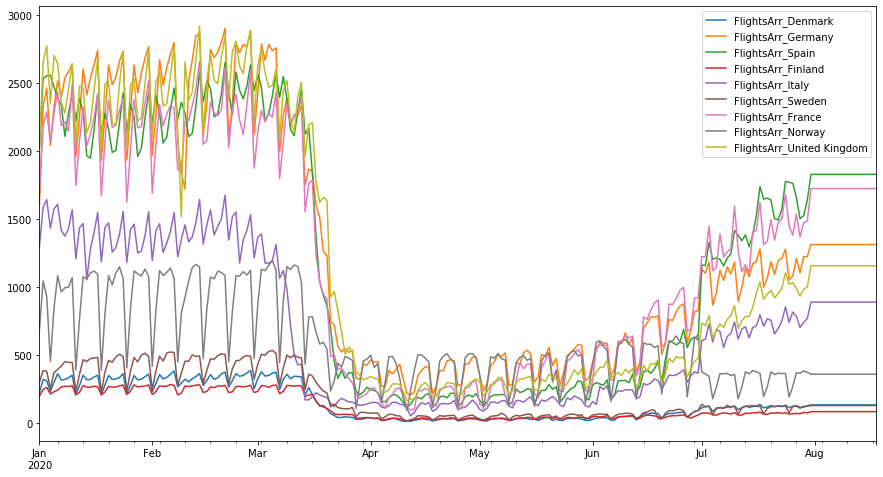

In [377]:
exogenas.loc[:, exogenas.columns.str.contains('Flights')].plot()

In [378]:
exogenas.shape

(231, 321)

In [184]:
#creating the csv file
#exogenas.to_csv('./data/exogenas.csv')

# Downloading and testing data (from Our World in Data)

In [379]:
covid = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv", parse_dates=["date"], index_col="date")

In [380]:
for i in covid["location"].unique():
  covid_country=covid[covid["location"]==i]
  covid_country_positive_rate=covid_country['positive_rate']
  covid_country_tests=covid_country['tests_per_case']
  covid_country_positive_rate.rename("Positive_rate_{}".format(i),inplace=True)
  covid_country_tests.rename("tests_per_case_{}".format(i),inplace=True)
  exogenas=pd.concat([exogenas,covid_country_positive_rate],axis=1)
  exogenas=pd.concat([exogenas,covid_country_tests],axis=1)


In [381]:
exogenas=exogenas.loc[:,exogenas.columns.str.contains('Denmark|Germany|Spain|Finland|Italy|Sweden|France|Norway|UK' \
                                                  '|USA|Canada|Mexico' \
                                                  '|Australia|Indonesia|Malaysia|Philippines|Thailand|Hong Kong|Vietnam|China|India|Japan|Singapore|Taiwan' \
                                                  '|Saudi Arabia|UAE|United Kingdom|United Arab Emirates|United States', regex=True)]
exogenas=exogenas.drop("Positive_rate_United States Virgin Islands",axis=1)
exogenas=exogenas.drop("tests_per_case_United States Virgin Islands",axis=1)

In [382]:
exogenas.shape

(233, 373)

In [383]:
exogenas

,schoolclosing_United Arab Emirates,schoolclosing_Australia,schoolclosing_Canada,schoolclosing_China,schoolclosing_Germany,schoolclosing_Denmark,schoolclosing_Spain,schoolclosing_Finland,schoolclosing_France,schoolclosing_United Kingdom,...,Positive_rate_Sweden,tests_per_case_Sweden,Positive_rate_Thailand,tests_per_case_Thailand,Positive_rate_Taiwan,tests_per_case_Taiwan,Positive_rate_United States,tests_per_case_United States,Positive_rate_Vietnam,tests_per_case_Vietnam
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-15,NaN,NaN,NaN,3.0,2.0,NaN,NaN,1.0,NaN,NaN,...,0.035,28.458,0.004,259.250,0.002,429.333,0.073,13.763,NaN,NaN
2020-08-16,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,NaN,NaN,...,0.035,28.661,0.004,276.231,0.003,318.500,0.070,14.253,NaN,NaN
2020-08-17,NaN,NaN,NaN,3.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.004,283.111,0.004,256.200,0.070,14.252,NaN,NaN
2020-08-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.003,297.370,0.004,260.400,0.069,14.572,NaN,NaN


In [384]:
exogenas[exogenas.index==pd.to_datetime("31-12-2019")]=exogenas[exogenas.index==pd.to_datetime("31-12-2019")].fillna(0)

In [385]:
exogenas.interpolate(method="linear",inplace=True)

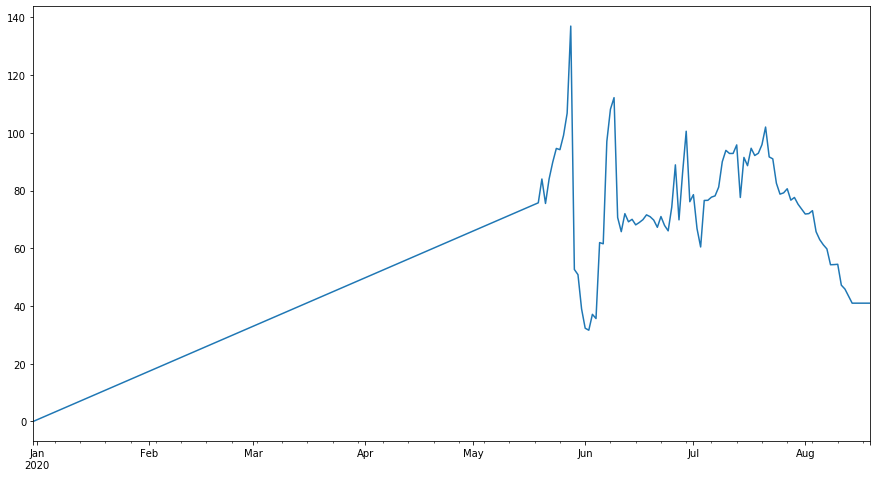

In [386]:
exogenas["tests_per_case_France"].plot()

In [388]:
#creating the csv file
exogenas.to_csv('./data/exogenas.csv')